In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
import sklearn as sklearn
from astropy.io import fits
from astropy.utils.data import download_file
from scipy import stats
from scipy.stats import norm, chi2
from sklearn.preprocessing import normalize


2023-07-26 14:16:34.972264: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 14:16:35.009025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 14:16:35.009680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 14:16:35.648813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

image_size = (511, 506)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 2847 files belonging to 2 classes.
Using 2278 files for training.
Using 569 files for validation.


In [5]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

# load the image
maskim = load_img('./mask.png')

plt.figure()
plt.imshow(maskim, cmap='gray_r')

# convert to numpy array
mask = img_to_array(maskim)

FileNotFoundError: [Errno 2] No such file or directory: './mask.png'

In [6]:
# plots with fit, stats

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):

        im = images[i]

        mat = mask.T
        maskdata = np.rollaxis(mat, 0, 3)  

        flatten = np.array(im).flatten()
        maskflatten = np.array(maskdata).flatten()

        data = flatten[maskflatten.astype(bool)]

        mu = np.average(data)
        sigma = np.std(data)
        bins = 15

# normalized distribution 
        histogram, bins = np.histogram(data, bins=15, density=True)

# gaussian
        y = norm.pdf(bins, mu, sigma)     

# fundamental stats
    # truncate last element to match up arrays
        y0 = np.delete(y, -1)

        absError = histogram - y0

        SE = np.square(absError) # squared errors
        MSE = np.mean(SE) # mean squared errors
        RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
        Rsquared = 1.0 - (np.var(absError) / np.var(y0))

    #print (absError, SE, MSE, RMSE, Rsquared)

        plt.figure()
    
        plt.subplot(121)

        plt.plot(bins, y, 'g', linewidth=2, linestyle='--')                                
        plt.axvline(mu, color='b', linewidth=2, linestyle='--')                                                                                        
        plt.title(r'$\ \mu=%.3f,\ \sigma=%.3f,\ r2=%.3f$' % (mu, sigma, Rsquared))     
        plt.plot(bins[0:-1], histogram)  

        plt.subplot(122)
    
        plt.title('image ' + str(i), fontsize=16)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray_r')
        plt.colorbar()

        plt.show() 



2023-07-26 10:00:10.959569: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 99289344 exceeds 10% of free system memory.


NameError: name 'mask' is not defined

<Figure size 1000x1000 with 0 Axes>

In [7]:
data_augmentation = keras.Sequential(
    [
#        layers.RandomFlip("horizontal"),
#        layers.RandomRotation(0.1),
    ]
)


In [8]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)


    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [32, 64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    
    
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

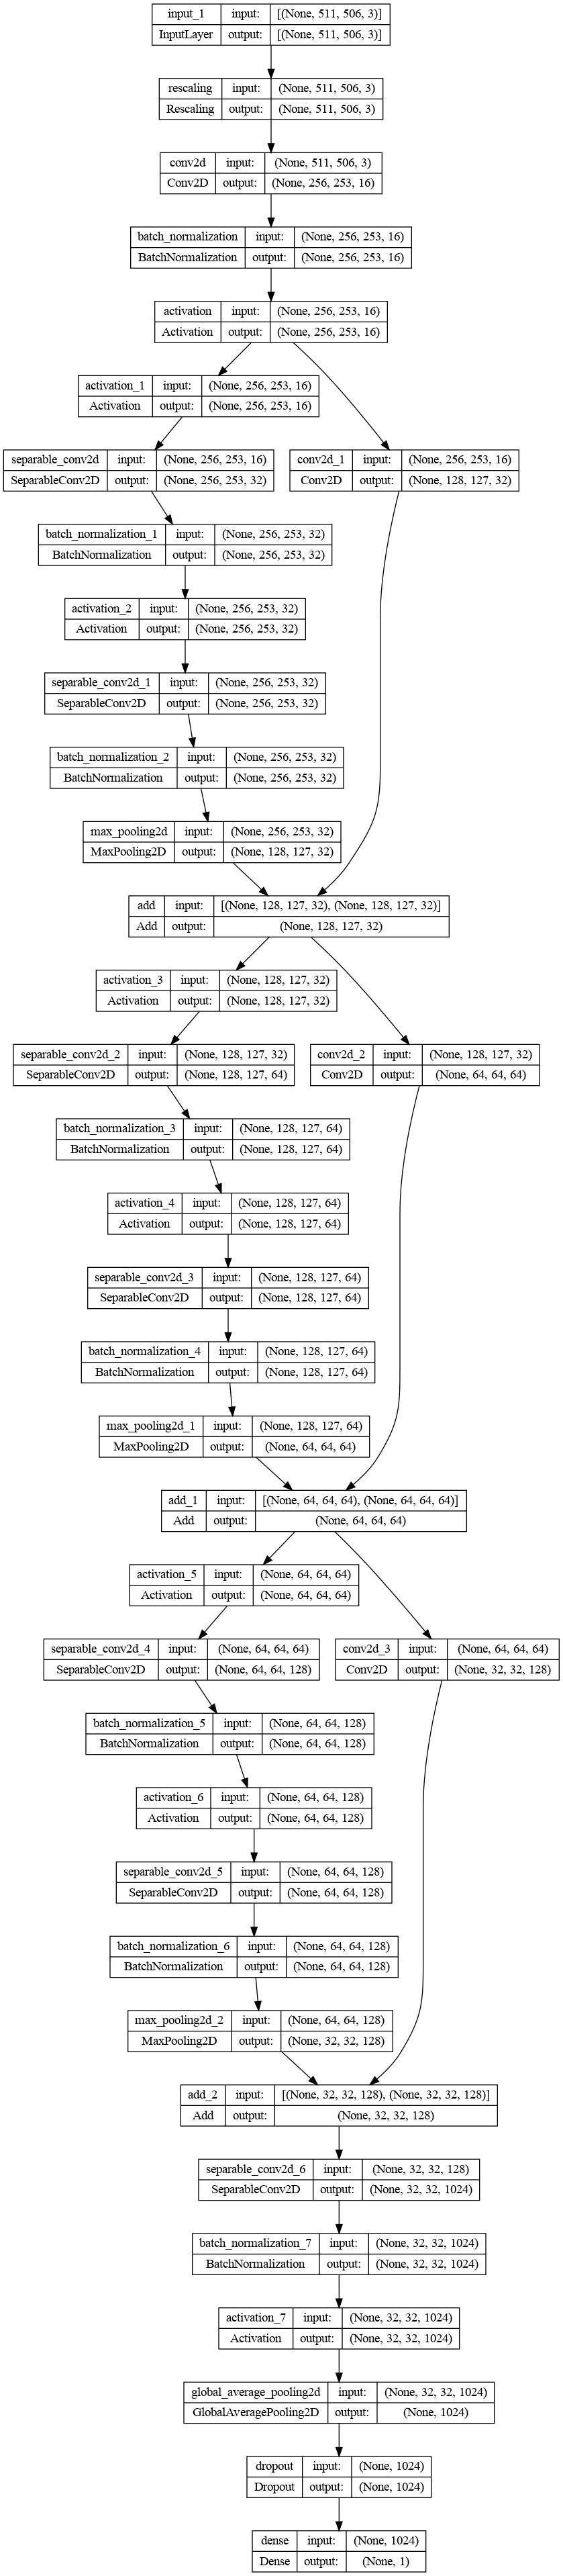

In [10]:
keras.utils.plot_model(model, show_shapes=True)


In [11]:

epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 511, 506, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 511, 506, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 253, 16)         448       ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 256, 253, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                               

                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 32, 128)          8320      ['add_1[0][0]']               
                                                                                                  
 add_2 (Add)                 (None, 32, 32, 128)          0         ['max_pooling2d_2[0][0]',     
                                                                     'conv2d_3[0][0]']            
                                                                                                  
 separable_conv2d_6 (Separa  (None, 32, 32, 1024)         133248    ['add_2[0][0]']               
 bleConv2D)                                                                                       
                                                                                                  
 batch_normalization_7 (Bat  (None, 32, 32, 1024)         4096      ['separable_conv2d_6[0][0]']  
 chNormali

In [ ]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/10


2023-07-26 10:00:49.208332: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 99289344 exceeds 10% of free system memory.
2023-07-26 10:00:49.274788: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132644864 exceeds 10% of free system memory.
2023-07-26 10:00:49.309427: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 99289344 exceeds 10% of free system memory.
2023-07-26 10:00:49.453480: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 132644864 exceeds 10% of free system memory.


In [ ]:
import glob
for i in glob.glob("test/*.png"):
    img = keras.utils.load_img(i, target_size=image_size)
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    predictions = model.predict(img_array, verbose=0)
    score = float(predictions[0])
    print(f"{i} is {100 * (1 - score):.2f}% clear and {100 * score:.2f}% cloud.")
    
    plt.figure()
    plt.imshow(img)
    plt.title(f"{100 * (1 - score):.2f}% clear and {100 * score:.2f}% cloud.")
    plt.axis("off")
    plt.show()

